In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.types import LongType, StringType, IntegerType, StructType, StructField, DecimalType, TimestampType

# Initialize Spark Session with MinIO and PostgreSQL configurations
spark = SparkSession.builder \
    .appName("app_bronze_to_silver_transactions") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "1") \
    .config("spark.cores.max", "3") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
    .config("spark.jars.packages", 
            "org.apache.hadoop:hadoop-aws:3.3.4,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.262,"
            "org.postgresql:postgresql:42.5.4") \
    .getOrCreate()

# Define schema for transactions
schema = StructType([
    StructField("id", LongType(), False),
    StructField("date", StringType(), False),  # Will convert to timestamp
    StructField("client_id", IntegerType(), False),
    StructField("card_id", IntegerType(), False),
    StructField("amount", StringType(), False),  # Read as string first
    StructField("use_chip", StringType(), False),
    StructField("merchant_id", IntegerType(), False),
    StructField("merchant_city", StringType(), True),
    StructField("merchant_state", StringType(), True),
    StructField("zip", StringType(), True),
    StructField("mcc", IntegerType(), True),
    StructField("errors", StringType(), True)
])

# Read CSV from MinIO
print("Reading data from MinIO...")
df = spark.read \
    .option("header", "true") \
    .schema(schema) \
    .csv("s3a://bronze/transactions/transactions_data.csv")

# Transform data
print("Transforming data...")
df_transformed = df \
    .withColumn("amount", regexp_replace(col("amount"), "\\$", "").cast(DecimalType(10, 2))) \
    .withColumn("date", col("date").cast(TimestampType()))

# Show sample data
print("Sample transformed data:")
df_transformed.show(5, truncate=False)

# Write to minio bucket
df_transformed.write.mode("overwrite").parquet("s3a://silver/transactions/")

print("Data loaded successfully!")

Reading data from MinIO...
Transforming data...
Sample transformed data:
+-------+-------------------+---------+-------+------+-----------------+-----------+-------------+--------------+-------+----+------+
|id     |date               |client_id|card_id|amount|use_chip         |merchant_id|merchant_city|merchant_state|zip    |mcc |errors|
+-------+-------------------+---------+-------+------+-----------------+-----------+-------------+--------------+-------+----+------+
|7475327|2010-01-01 00:01:00|1556     |2972   |-77.00|Swipe Transaction|59935      |Beulah       |ND            |58523.0|5499|NULL  |
|7475328|2010-01-01 00:02:00|561      |4575   |14.57 |Swipe Transaction|67570      |Bettendorf   |IA            |52722.0|5311|NULL  |
|7475329|2010-01-01 00:02:00|1129     |102    |80.00 |Swipe Transaction|27092      |Vista        |CA            |92084.0|4829|NULL  |
|7475331|2010-01-01 00:05:00|430      |2860   |200.00|Swipe Transaction|27092      |Crown Point  |IN            |46307.0|48

In [2]:
print("Stopping spark session")
spark.stop()
print("spark session stopped successfully")

Stopping spark session
spark session stopped successfully


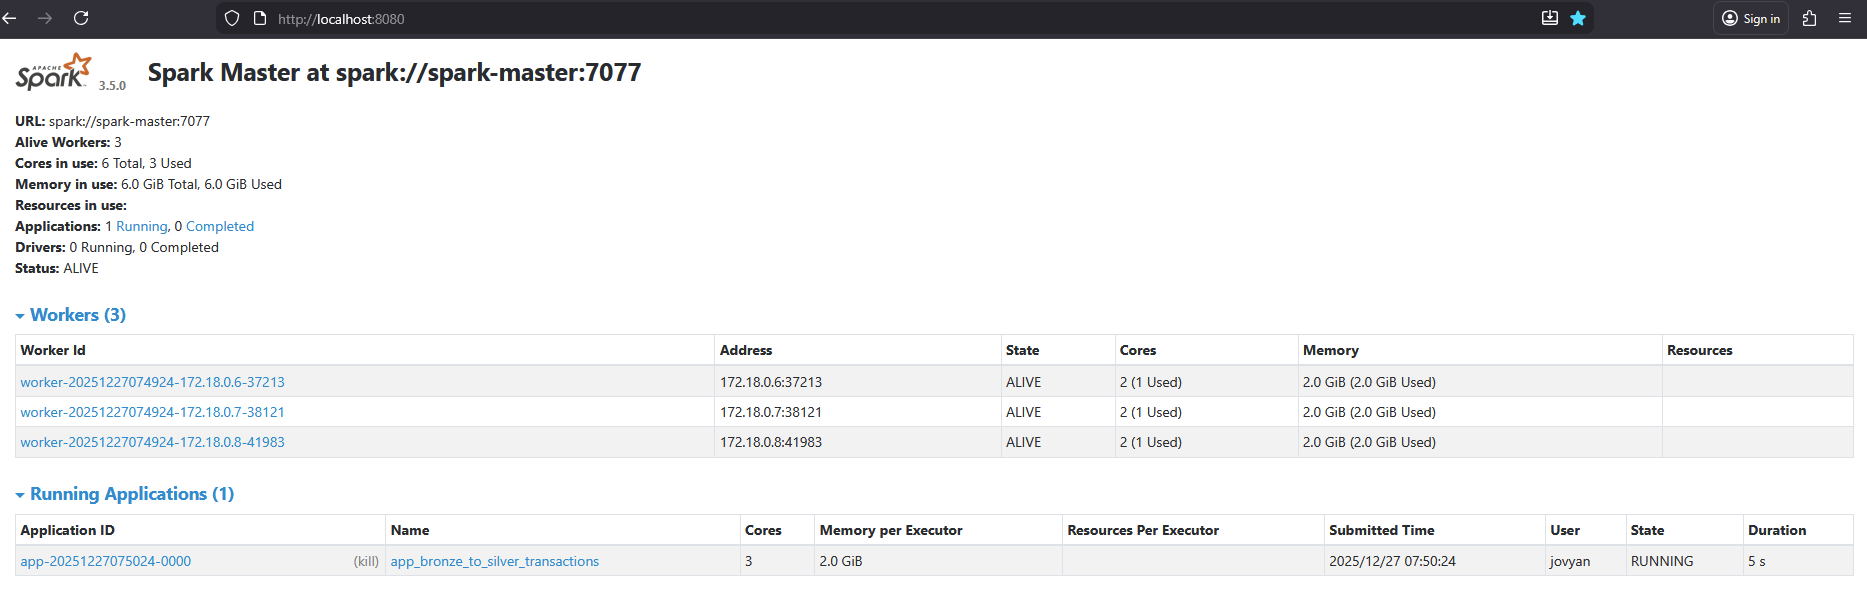

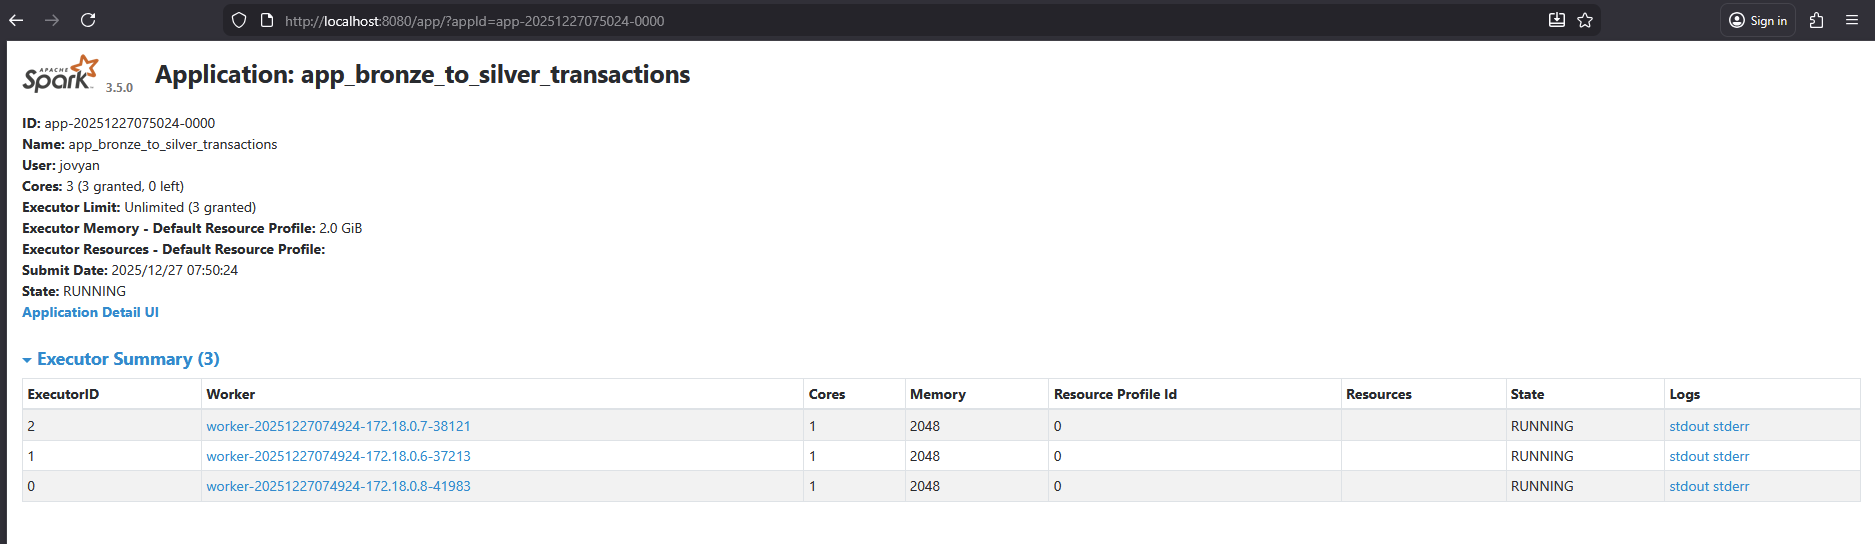